In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp

from aeons.endpoint import EndModel, IncrementEndpoint, endpoints_calc, logXf_formula, reject_outliers
from aeons.tools import pickle_dump, pickle_in, proj_dir, chains, write_to_txt, read_from_txt, get_samples
from aeons.likelihoods import full
from aeons.lm_partial import analytic_lm_params
from aeons.true_distribution import generate_Xs
from aeons.covariance import points_at_iteration
from aeons.models import LS

/home/zixiao/Documents/III/project/aeons/aeons/covariance.py:89: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def X_mu(nk):
/home/zixiao/Documents/III/project/aeons/aeons/covariance.py:95: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def X_Sigma(nk):


In [2]:
def plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.1, logX_vals=None):
    # plt.plot(iterations, endpoints, lw=1, color='navy')
    if logX_vals is not None:
        iterations = -logX_vals
        xlim = logX_vals[-1]
    plt.fill_between(iterations, endpoints - endpoints_std, endpoints + endpoints_std, alpha=1, color='deepskyblue')
    plt.fill_between(iterations, endpoints - 2*endpoints_std, endpoints + 2*endpoints_std, alpha=.2, color='deepskyblue')
    plt.axhline(y=true_endpoint, lw=1, color='navy')
    plt.ylim(0, true_endpoint*ylim)

def calc_logXfs(iterations, samples, number=3, N=10):
    logXfs = np.zeros_like(iterations, dtype=float)
    logXfs_std = np.zeros_like(iterations, dtype=float)
    for k, ndead in enumerate(iterations):
        points = points_at_iteration(samples, ndead)
        logXi = points.logX().iloc[ndead]
        logL = points.logL
        logXfs_i = np.zeros(N)
        for i in range(N):
            logZdead = m.logZ.iloc[ndead]
            Xi = generate_Xs(points.nlive)
            theta = analytic_lm_params(logL[-number:], Xi[-number:], 1)
            logXfs_i[i] = logXf_formula(theta, logZdead, np.exp(logXi))
        logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
        logXfs[k] = np.mean(logXfs_i)
        logXfs_std[k] = np.std(logXfs_i)
        print(f'Iteration {ndead}/{iterations[-1]}')
    return logXfs, logXfs_std

def formatt(theta):
    return [f"{t:.2f}" for t in theta]

### **Prediction uncertainty from last few points**
Does well at expanding errorbars, given some small manual tweaking of how many points to use. 

#### BAO

In [312]:
name, samples = get_samples('lcdm', 'BAO')
model = EndModel(samples)
m = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = m.true_endpoint
logXf_true = samples.logX().iloc[true_endpoint]
true_endpoint, logXf_true

(18129, -11.427123628714591)

In [329]:
ndead = 2000
points = model.points(ndead)
logL, logX = samples.logL, samples.logX()
L, X = np.exp(logL), np.exp(logX)
logZdead = m.logZ.iloc[ndead]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [370]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs, logXfs_std = calc_logXfs(iterations, samples, number=5, N=25)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:21: RuntimeWarning: invalid value encountered in double_scalars
  loglive = np.log( gamma(d/2) * gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )


Iteration 1812/17476
Iteration 2465/17476
Iteration 3118/17476
Iteration 3770/17476
Iteration 4423/17476
Iteration 5076/17476
Iteration 5728/17476
Iteration 6381/17476
Iteration 7034/17476
Iteration 7686/17476
Iteration 8339/17476
Iteration 8991/17476
Iteration 9644/17476
Iteration 10297/17476
Iteration 10949/17476
Iteration 11602/17476
Iteration 12255/17476
Iteration 12907/17476
Iteration 13560/17476
Iteration 14213/17476
Iteration 14865/17476
Iteration 15518/17476
Iteration 16171/17476
Iteration 16823/17476
Iteration 17476/17476


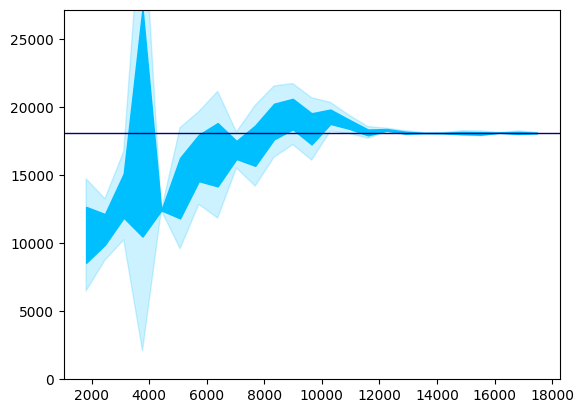

In [371]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

In [334]:
number = 3
logXi = points.logX().iloc[ndead]
logL = points.logL

N = 20
logXfs = np.zeros(N)
for i in range(N):
    Xi = generate_Xs(points.nlive)
    theta = analytic_lm_params(logL[-number:], Xi[-number:], 1)
    logXfs[i] = logXf_formula(theta, logZdead, np.exp(logXi))
logXfs = logXfs[~np.isnan(logXfs)]

endpoints_calc(ndead, logXi, np.mean(logXfs), np.std(logXfs), nlive=1000)

(15381.684620603566, 4871.27103606243)

#### LBAO

In [373]:
name, samples = get_samples('lcdm', 'lensing_BAO')
model = EndModel(samples)
m = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = m.true_endpoint
logXf_true = samples.logX().iloc[true_endpoint]
true_endpoint, logXf_true

(22108, -15.404135454054247)

In [374]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs, logXfs_std = calc_logXfs(iterations, samples, number=5, N=25)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 2210/21312


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


Iteration 3006/21312
Iteration 3802/21312
Iteration 4598/21312
Iteration 5394/21312
Iteration 6190/21312
Iteration 6986/21312
Iteration 7782/21312
Iteration 8577/21312


/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:21: RuntimeWarning: invalid value encountered in double_scalars
  loglive = np.log( gamma(d/2) * gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )


Iteration 9373/21312
Iteration 10169/21312
Iteration 10965/21312
Iteration 11761/21312
Iteration 12557/21312
Iteration 13353/21312
Iteration 14149/21312
Iteration 14945/21312
Iteration 15740/21312
Iteration 16536/21312
Iteration 17332/21312


/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:41: RuntimeWarning: divide by zero encountered in divide
  (Xdata**(2/d)) / (2 * sigma_squared_analytic(d, Xdata, logLdata)) )
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:40: RuntimeWarning: invalid value encountered in subtract
  return logLdata - (logLmax_analytic(d, Xdata, logLdata) - \


Iteration 18128/21312
Iteration 18924/21312
Iteration 19720/21312
Iteration 20516/21312
Iteration 21312/21312


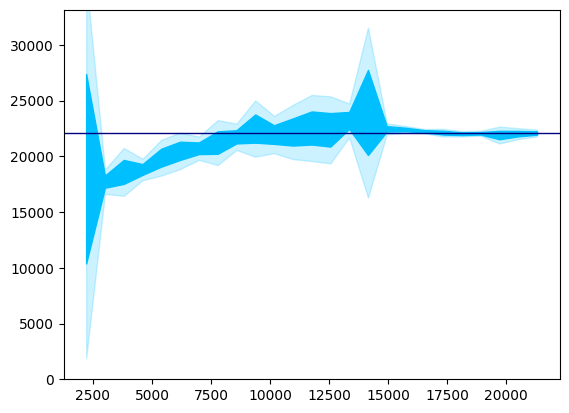

In [375]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

#### SH0ES

In [376]:
name, samples = get_samples('lcdm', 'SH0ES')
model = EndModel(samples)
m = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = m.true_endpoint
logXf_true = samples.logX().iloc[true_endpoint]
true_endpoint, logXf_true

(15096, -8.886403351698142)

In [390]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 10, endpoint=False).astype(int)
logXfs, logXfs_std = calc_logXfs(iterations, samples, number=3, N=25)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 1509/13737
Iteration 2868/13737
Iteration 4226/13737
Iteration 5585/13737
Iteration 6944/13737
Iteration 8302/13737


/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:28: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigma_squared_analytic(d, Xdata, logLdata))
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator/denominator
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:21: RuntimeWarning: divide by zero encountered in log
  loglive = np.log( gamma(d/2) * gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:25: RuntimeWarning: invalid value encountered in double_scalars
  return d/2 * np.log(2*sigma**2 * xf_reg)


Iteration 9661/13737
Iteration 11020/13737
Iteration 12378/13737
Iteration 13737/13737


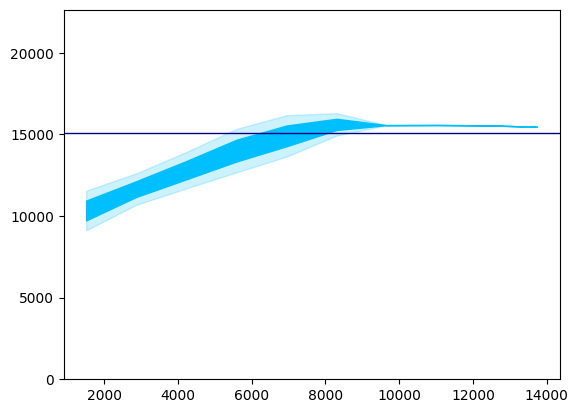

In [391]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

#### Planck-lensing

In [468]:
name, samples = get_samples('lcdm', 'planck_lensing')
model = EndModel(samples)
m = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = m.true_endpoint
logXf_true = samples.logX().iloc[true_endpoint]
true_endpoint, logXf_true

(58100, -51.3781514423304)

In [ ]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 10, endpoint=False).astype(int)
logXfs, logXfs_std = calc_logXfs(iterations, samples, number=4, N=25)

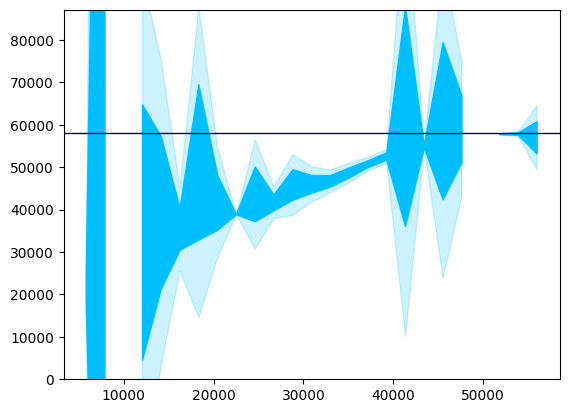

In [470]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

#### Cauchy
Doesn't work well with Cauchy

In [293]:
samples = pickle_in('../../samples/toy/cauchy_10_0001.pickle')
model = EndModel(samples)
m = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = m.true_endpoint
logXf_true = samples.logX().iloc[true_endpoint]

In [290]:
ndead = 4000
points = model.points(ndead)
logL, logX = samples.logL, samples.logX()
L, X = np.exp(logL), np.exp(logX)
logZdead = m.logZ.iloc[ndead]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [299]:
number = 10
logXi = points.logX().iloc[ndead]
logL = points.logL
for i in range(10):
    Xi = generate_Xs(points.nlive)
    theta = analytic_lm_params(logL[-number:], Xi[-number:], 1)
    logXf = logXf_formula(theta, logZdead, np.exp(logXi))
    print(logXf)

-21.32338469418451
nan
-19.631070674379703
nan
nan
-20.03970628388546
-19.42032649312145
-19.61765503525578
nan
-20.017877246530965


In [294]:
logXf_true

-95.89613579769184

### **Detecting LX plot maximum crossed**

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


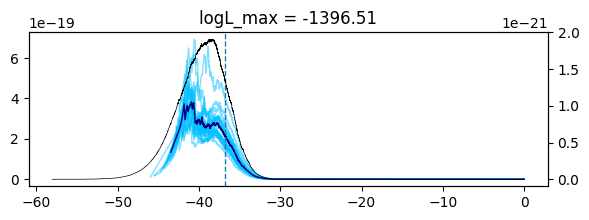

In [26]:
ndead = 43500
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)

fig, ax = plt.subplots(figsize=(6.7,2))
logL_norm = points.logL - points.logL.max()
L_norm = np.exp(logL_norm)

Nset = 25
Xset = np.zeros((Nset, len(nk)))
LXset = np.zeros_like(Xset)
for i in range(Nset):
    Xs = generate_Xs(nk)
    ax.plot(np.log(Xs), L_norm * Xs, lw=1, alpha=0.5, color='deepskyblue')
    Xset[i] = Xs
    LXset[i] = L_norm * Xs
ax.plot(np.log(np.mean(Xset, axis=0)), np.mean(LXset, axis=0), lw=1, color='navy')
# ax.plot(points.logX(), L_norm*np.exp(points.logX()))
ax.set_title(f'logL_max = {points.logL.max():.2f}')
ax.axvline(x=points.logX().iloc[ndead], ls='--', lw=1)

ax1 = plt.twinx(ax)
ax1.plot(samples.logX(), np.exp(samples.logL - samples.logL.max()) * np.exp(samples.logX()), lw=.5, color='black')

### **Exclusion of live points**

In [5]:
def logZ(logPmax, H, D, details=False):
    if details:
        print(f"logPr_max: {logPmax}, Hessian: {- 1/2 * np.log(abs(np.linalg.det(H)))}")
    return logPmax - 1/2 * np.log(abs(np.linalg.det(H))) + D/2 * np.log(2*np.pi)

class GaussianRegress:
    def __init__(self, logL, X):
        self.logL = np.array(logL)
        self.X = np.array(X)
        self.N = len(logL)
        try:
            self.theta = analytic_lm_params(self.logL, self.X, d0=1)
        except:
            print('Bad data')
            self.theta = np.nan
    
    def L_sq(self, theta):
        loss = self.logL - full.func(self.X, theta)
        return np.sum(loss**2)
    
    def s(self, theta):
        return np.sqrt(self.L_sq(theta)/self.N)
    
    def logPr(self, theta):
        L_sq = self.L_sq(theta)
        s = np.sqrt(L_sq/self.N)
        return -1/2 * self.N * np.log(2*np.pi*s**2) - L_sq/(2*s**2)
    
    def logZ(self, theta_max=None, details=False):
        if theta_max == None:
            theta_max = self.theta
        logPr_max = self.logPr(theta_max)
        H = self.hess(theta_max)
        D = len(theta_max) + 1
        return logZ(logPr_max, H, D, details)
    
    def hess(self, theta_max=None):
        import torch
        from torch.autograd.functional import hessian
        if theta_max == None:
            theta_max = self.theta
        s = self.s(theta_max)
        logL = torch.from_numpy(self.logL)
        mean = torch.from_numpy(self.X)
        theta_s_max = torch.tensor([*theta_max, s], requires_grad=True)
        def func(theta_s):
            *theta, s = theta_s
            loss = logL - full.func(mean, theta, torched=True)
            L_sq = torch.sum(loss**2)
            return -1/2 * self.N * torch.log(2*torch.pi*s**2) - L_sq/(2*s**2)
        H = hessian(func, theta_s_max)
        return np.array(H)
    
    def covtheta(self, theta_max=None):
        """Redefine to exclude rows/columns with covariance of s"""
        if theta_max == None:
            theta_max = self.theta
        Dtheta = len(theta_max)
        H = self.hess(theta_max)
        return np.linalg.inv(-H[:Dtheta, :Dtheta])
    
def minimise_exclude(logL, X, print_split=False):
    logL, X = np.array(logL), np.array(X)
    logZmax = -np.inf
    theta_best = None
    split_best = None
    for splits in range(1, 5):
        start = len(X) - int(len(X)/splits)
        Xs, logLs = X[start:], logL[start:]
        regress = GaussianRegress(logLs, Xs)
        logZ = regress.logZ()
        theta = regress.theta
        if logZ > logZmax:
            logZmax = logZ
            theta_best = theta
            split_best = splits
    if print_split:
        print(f"Best split: {split_best}, {theta_best}")
    return theta_best

def minimise_bandwidth(logL, X, logZdead, print_split=False):
    logZmax = -np.inf
    theta_best = None
    split_best = None
    for splits in range(1, 5):
        start = len(X) - int(len(X)/splits)
        Xs, logLs = X[start:], logL[start:]
        regress = GaussianRegress(logLs, Xs)
        theta = regress.theta
        # if np.isnan(logXf_formula(theta, logZdead, X[0])):
            # continue
        logZ = regress.logZ()
        if logZ > logZmax:
            logZmax = logZ
            theta_best = theta
            split_best = splits
    if print_split:
        print(f"Best split: {split_best}, {theta_best}")
    return theta_best

def reject_outliers(data):
    data = np.array(data)
    dev = np.abs(data - np.median(data))
    median_dev = np.median(dev)
    return data[dev < 3 * median_dev]

#### BAO

In [385]:
name, samples = get_samples('lcdm', 'BAO')
model = EndModel(samples)
inc = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = inc.true_endpoint
logZs = inc.logZ

In [67]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 10, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=10)
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 1812/16497
Iteration 3444/16497
Iteration 5076/16497
Iteration 6707/16497
Iteration 8339/16497
Iteration 9970/16497
Iteration 11602/16497
Iteration 13234/16497
Iteration 14865/16497
Iteration 16497/16497


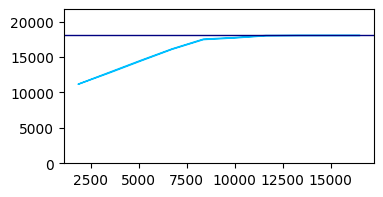

In [68]:
plt.figure(figsize=(4, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

In [206]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 10, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 10
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    irange = np.linspace(ndead, len(points), 60, endpoint=False).astype(int)
    logL = points.logL.iloc[irange]
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        theta = minimise_exclude(logL, X[irange])
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    print(f"{ndead}/{iterations[-1]}, {formatt(np.mean(thetas, axis=0))}")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


1812/16497, ['-3.83', '2.04', '0.10']
3444/16497, ['-3.90', '2.04', '0.10']
5076/16497, ['-3.71', '2.15', '0.10']
6707/16497, ['-3.72', '2.11', '0.10']
8339/16497, ['-3.73', '2.10', '0.10']
9970/16497, ['-3.61', '2.37', '0.12']
11602/16497, ['-3.29', '4.26', '0.23']
13234/16497, ['-3.19', '5.30', '0.29']
14865/16497, ['-3.17', '6.36', '0.35']
16497/16497, ['-3.19', '5.98', '0.33']


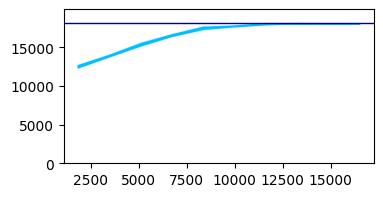

In [207]:
endpoints, endpoints_std = endpoints_calc(iterations, samples.logX().iloc[iterations], logXfs, logXfs_std, nlive=1000)
plt.figure(figsize=(4, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint)

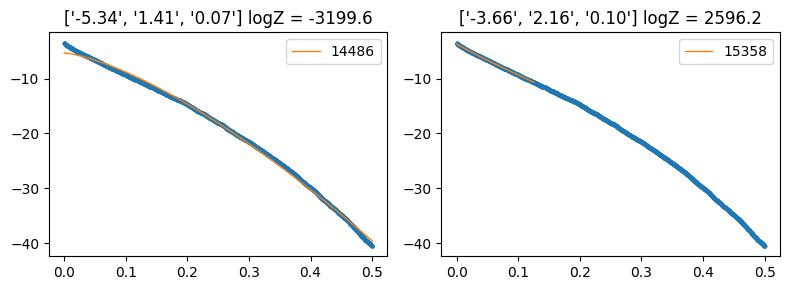

In [387]:
# Showing non-Gaussian/prior artefact at early iterations, which causes poor predictions
ndead = 5000
logZdead = logZs.iloc[ndead]
points = points_at_iteration(samples, ndead)
splits = 4
trunc = 1
logXi, logLi = points.logX().iloc[ndead:-trunc], points.logL.iloc[ndead:-trunc]
Xi, Li = np.exp(logXi), np.exp(logLi)
start = len(Xi) - int(len(Xi)/splits)
Xi1, logLi1 = Xi[start:], logLi[start:]

regress = GaussianRegress(logLi, Xi)
regress1 = GaussianRegress(logLi1, Xi1)
logXf = logXf_formula(regress.theta, logZdead, Xi.iloc[0])
endpoint = endpoints_calc(ndead, np.log(Xi.iloc[0]), logXf, 0.01, nlive=1000)[0]
logXf1 = logXf_formula(regress1.theta, logZdead, Xi.iloc[0])
endpoint1 = endpoints_calc(ndead, np.log(Xi.iloc[0]), logXf1, 0.01, nlive=1000)[0]

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(Xi, logLi, '+', ms=3)
axs[0].plot(Xi, full.func(Xi, regress.theta), lw=1, label=f"{endpoint:.0f}")
axs[0].set_title(f"{[f'{t:.2f}' for t in regress.theta]} logZ = {regress.logZ():.1f}")
axs[0].legend()

axs[1].plot(Xi, logLi, '+', ms=3)
axs[1].plot(Xi1, full.func(Xi1, regress1.theta), lw=1, label=f"{endpoint1:.0f}")
axs[1].set_title(f"{[f'{t:.2f}' for t in regress1.theta]} logZ = {regress1.logZ():.1f}");
axs[1].legend()

fig.tight_layout()

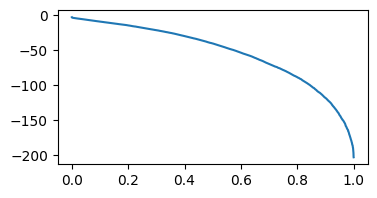

In [69]:
logX, logL = samples.logX(), samples.logL
X, L = np.exp(logX), np.exp(logL)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(X, logL)

#### Planck lensing BAO

In [3]:
name, samples = get_samples('lcdm', 'planck_lensing_BAO')
model = EndModel(samples)
inc = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = inc.true_endpoint
logZs = inc.logZ

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


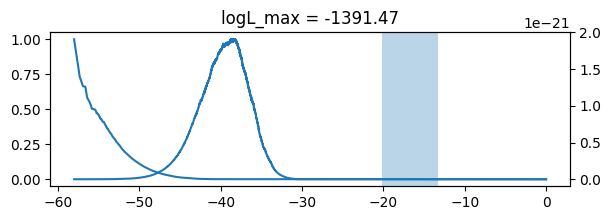

In [444]:
model.plot_lx()
ndead = 20000
points = points_at_iteration(samples, ndead)
start, end = points.logX().iloc[[ndead, -1]]
plt.axvspan(start, end, alpha=.3)

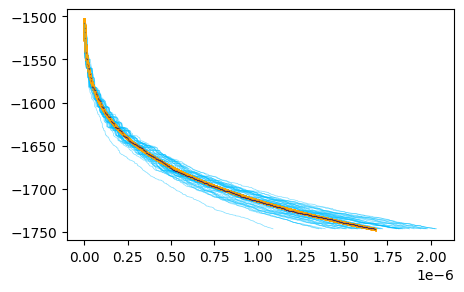

In [467]:
plt.figure(figsize=(5,3))
nk, logL = np.array(points.nlive), np.array(points.logL)
X_mean = np.array(np.exp(points.logX()))
regress = GaussianRegress(logL[ndead:], X_mean[ndead:])
covtheta = regress.covtheta()
X_sample = np.array(np.exp(samples.logX()))
for i in range(50):
    X = generate_Xs(nk)
    theta = np.random.multivariate_normal(regress.theta, covtheta)
    plt.plot(X_mean[ndead:], full.func(X_mean[ndead:], theta), lw=2, color='orange')
    plt.plot(X[ndead:], logL[ndead:], lw=.5, alpha=.5, color='deepskyblue')
plt.plot(X_mean[ndead:], logL[ndead:], '+', ms=.1, color='navy')

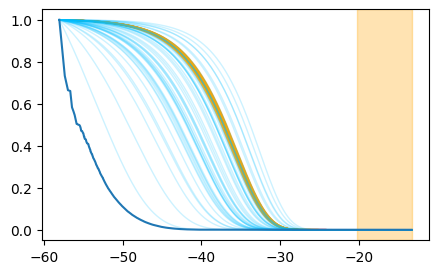

In [462]:
plt.figure(figsize=(5,3))
for i in range(50):
    theta = np.random.multivariate_normal(regress.theta, covtheta)
    logL_pred = full.func(X_sample[ndead:], theta)
    plt.plot(np.log(X_sample)[ndead:], np.exp(logL_pred - logL_pred.max()), lw=1, alpha=.5, color='orange')
for i in range(50):
    X = generate_Xs(nk)
    regress = GaussianRegress(logL[ndead:], X[ndead:])
    theta = regress.theta
    logL_pred = full.func(X_sample[ndead:], theta)
    plt.plot(np.log(X_sample)[ndead:], np.exp(logL_pred - logL_pred.max()), lw=1, alpha=.2, color='deepskyblue')
plt.plot(np.log(X_sample[ndead:]), np.exp(samples.logL.iloc[ndead:] - samples.logL.max()))
plt.axvspan(start, end, alpha=.3, color='orange')

In [424]:
def parameter_uncertainty(logL, nk, ndead, Nset=10):
    thetas = np.zeros((Nset, 3))
    for i in range(Nset):
        X = generate_Xs(nk)
        regress = GaussianRegress(logL[ndead:], X[ndead:])
        thetas[i] = regress.theta
    return np.mean(thetas, axis=0), np.std(thetas, axis=0)

In [471]:
# Least squares uncertainty
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
thetas_ls = np.zeros((len(iterations), 3))
thetas_ls_std = np.zeros((len(iterations), 3))
for k, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    X_mean = np.array(np.exp(points.logX()))
    logL = np.array(points.logL)
    regress = GaussianRegress(logL[ndead:], X_mean[ndead:])
    thetas_ls[k] = regress.theta
    thetas_ls_std[k] = np.sqrt(np.diagonal(regress.covtheta()))
    print(f'Iteration {ndead}/{iterations[-1]}')

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 5810/56008
Iteration 7901/56008
Iteration 9993/56008
Iteration 12084/56008
Iteration 14176/56008
Iteration 16268/56008
Iteration 18359/56008
Iteration 20451/56008
Iteration 22542/56008
Iteration 24634/56008
Iteration 26726/56008
Iteration 28817/56008
Iteration 30909/56008
Iteration 33000/56008
Iteration 35092/56008
Iteration 37184/56008
Iteration 39275/56008
Iteration 41367/56008
Iteration 43458/56008
Iteration 45550/56008
Iteration 47642/56008
Iteration 49733/56008
Iteration 51825/56008
Iteration 53916/56008
Iteration 56008/56008


In [472]:
# Volume uncertainty
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
thetas_vol = np.zeros((len(iterations), 3))
thetas_vol_std = np.zeros((len(iterations), 3))
for k, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    theta, theta_std = parameter_uncertainty(logL, nk, ndead)
    thetas_vol[k] = theta
    thetas_vol_std[k] = theta_std
    print(f'Iteration {ndead}/{iterations[-1]}')

Iteration 5810/56008
Iteration 7901/56008
Iteration 9993/56008
Iteration 12084/56008
Iteration 14176/56008
Iteration 16268/56008
Iteration 18359/56008
Iteration 20451/56008
Iteration 22542/56008
Iteration 24634/56008
Iteration 26726/56008
Iteration 28817/56008
Iteration 30909/56008
Iteration 33000/56008
Iteration 35092/56008
Iteration 37184/56008
Iteration 39275/56008
Iteration 41367/56008
Iteration 43458/56008
Iteration 45550/56008
Iteration 47642/56008
Iteration 49733/56008
Iteration 51825/56008
Iteration 53916/56008
Iteration 56008/56008


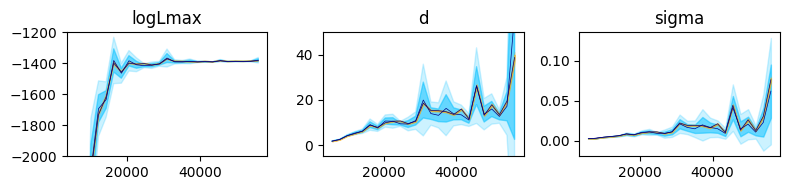

In [474]:
titles = ['logLmax', 'd', 'sigma']
fig, axs = plt.subplots(1, 3, figsize=(8, 2))
for i, ax in enumerate(axs):
    means_vol = thetas_vol[:,i]
    stds_vol = thetas_vol_std[:,i]
    ax.plot(iterations, means_vol, lw=.5, color='navy')
    ax.fill_between(iterations, means_vol - stds_vol, means_vol + stds_vol, alpha=.5, color='deepskyblue')
    ax.fill_between(iterations, means_vol - 2*stds_vol, means_vol + 2*stds_vol, alpha=.2, color='deepskyblue')
    ax.set_title(titles[i])

    means_ls = thetas_ls[:,i]
    stds_ls = thetas_ls_std[:,i]
    ax.plot(iterations, means_ls, lw=.5, color='navy')
    ax.fill_between(iterations, means_ls - stds_ls, means_ls + stds_ls, alpha=.5, color='orange')
    ax.fill_between(iterations, means_ls - 2*stds_ls, means_ls + 2*stds_ls, alpha=.2, color='orange')
axs[0].set_ylim(-2000, -1200)
axs[1].set_ylim(-5, 50)
fig.tight_layout()

In [422]:
# Vanilla
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=25)
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


KeyboardInterrupt: 

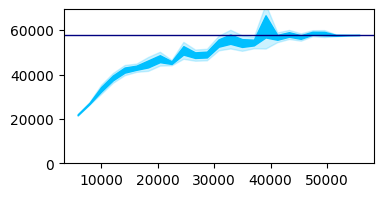

In [311]:
plt.figure(figsize=(4, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

In [ ]:
# Minimise excluding live points
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    # irange = np.linspace(ndead, len(points), 720, endpoint=False).astype(int)
    logL = points.logL.iloc[ndead:]#.iloc[irange]
    logX = points.logX()
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        # theta = minimise_exclude(logL, X[irange], print_split=True)
        theta = minimise_exclude(logL, X[ndead:], print_split=False)
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    print(f"{ndead}/{iterations[-1]}, {formatt(np.median(thetas, axis=0))}")

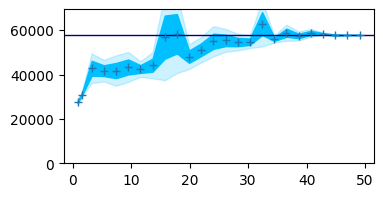

In [381]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2, logX_vals=logXs)
plt.plot(-logXs, endpoints, '+')

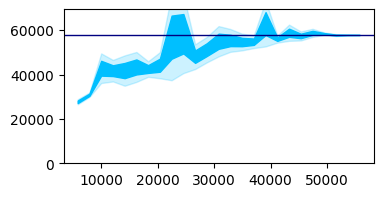

In [373]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)#, logX_vals=logXs)

In [252]:
# Exclude last few points if they cause overflow
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
trunc = 15
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = points.logL.iloc[ndead:]
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        theta = minimise_bandwidth(logL, X[ndead:], logZdead, print_split=False)
        attempt = 1
        while np.isnan(logXf_formula(theta, logZdead, X[ndead])):
            theta = minimise_bandwidth(logL[:-attempt*trunc], X[ndead:-attempt*trunc], logZdead, print_split=False)
            attempt += 1
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    # logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    # print(thetas)
    print(f"{ndead}/{iterations[-1]}, {len(logXfs_i)}, attempts={attempt}")#, {formatt(np.mean(thetas, axis=0))}")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


5785/55769, 23, attempts=1
7867/55769, 25, attempts=1
9950/55769, 24, attempts=1
12033/55769, 22, attempts=1
14115/55769, 22, attempts=1
16198/55769, 22, attempts=1
18281/55769, 22, attempts=1
20363/55769, 20, attempts=1


/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


22446/55769, 18, attempts=3
24529/55769, 20, attempts=1


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)


26611/55769, 23, attempts=1
28694/55769, 22, attempts=1
30777/55769, 22, attempts=1
32859/55769, 20, attempts=1
34942/55769, 23, attempts=1
37025/55769, 24, attempts=1
39107/55769, 21, attempts=1
41190/55769, 21, attempts=1
43273/55769, 21, attempts=1
45355/55769, 24, attempts=1
47438/55769, 23, attempts=1


/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:21: RuntimeWarning: invalid value encountered in double_scalars
  loglive = np.log( gamma(d/2) * gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )


49521/55769, 25, attempts=1
51603/55769, 21, attempts=1
53686/55769, 22, attempts=1
55769/55769, 25, attempts=1


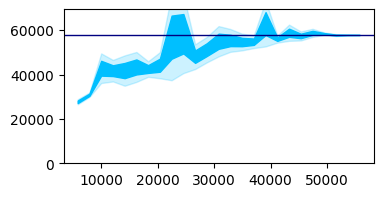

In [384]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

Examine particular iteration

In [ ]:
ndead = 50000
points = points_at_iteration(samples, ndead)
irange = np.arange(ndead, len(points), 50)
logXi, logLi = points.logX().iloc[irange], points.logL.iloc[irange]
Xi, Li = np.exp(logXi), np.exp(logLi)
theta_40000 = GaussianRegress(logLi, Xi).theta

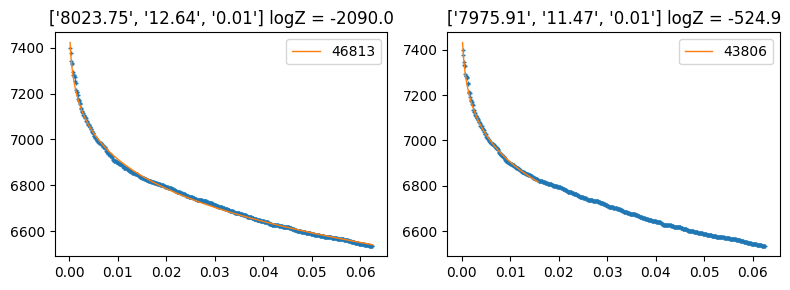

In [10]:
# Showing non-Gaussian/prior artefact at early iterations, which causes poor predictions
ndead = 2000
logZdead = logZs.iloc[ndead]
points = points_at_iteration(samples, ndead)
splits = 4
trunc = 1
logXi, logLi = points.logX().iloc[ndead:-trunc], points.logL.iloc[ndead:-trunc]
Xi, Li = np.exp(logXi), np.exp(logLi)
start = len(Xi) - int(len(Xi)/splits)
Xi1, logLi1 = Xi[start:], logLi[start:]

regress = GaussianRegress(logLi, Xi)
regress1 = GaussianRegress(logLi1, Xi1)
logXf = logXf_formula(regress.theta, logZdead, Xi.iloc[0])
endpoint = endpoints_calc(ndead, np.log(Xi.iloc[0]), logXf, 0.01, nlive=1000)[0]
logXf1 = logXf_formula(regress1.theta, logZdead, Xi.iloc[0])
endpoint1 = endpoints_calc(ndead, np.log(Xi.iloc[0]), logXf1, 0.01, nlive=1000)[0]

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(Xi, logLi, '+', ms=3)
axs[0].plot(Xi, full.func(Xi, regress.theta), lw=1, label=f"{endpoint:.0f}")
axs[0].set_title(f"{[f'{t:.2f}' for t in regress.theta]} logZ = {regress.logZ():.1f}")
axs[0].legend()

axs[1].plot(Xi, logLi, '+', ms=3)
axs[1].plot(Xi1, full.func(Xi1, regress1.theta), lw=1, label=f"{endpoint1:.0f}")
axs[1].set_title(f"{[f'{t:.2f}' for t in regress1.theta]} logZ = {regress1.logZ():.1f}");
axs[1].legend()

fig.tight_layout() # fig.suptitle(f"Theta(40,000): {[f'{t:.2f}' for t in theta_40000]}", y=1.05)

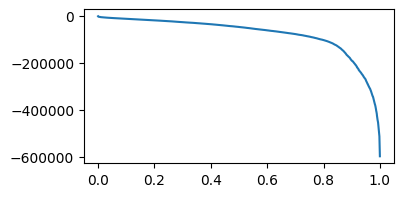

In [54]:
logX, logL = samples.logX(), samples.logL
X, L = np.exp(logX), np.exp(logL)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(X, logL)

#### Lensing SH0ES

In [194]:
name, samples = get_samples('lcdm', 'lensing_SH0ES')
model = EndModel(samples)
inc = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = inc.true_endpoint
logZs = inc.logZ

In [12]:
# Vanilla approach
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=25)
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 2067/19927
Iteration 2811/19927
Iteration 3555/19927
Iteration 4299/19927
Iteration 5043/19927
Iteration 5788/19927
Iteration 6532/19927
Iteration 7276/19927
Iteration 8020/19927
Iteration 8764/19927
Iteration 9509/19927
Iteration 10253/19927
Iteration 10997/19927
Iteration 11741/19927
Iteration 12485/19927
Iteration 13230/19927
Iteration 13974/19927
Iteration 14718/19927
Iteration 15462/19927
Iteration 16206/19927
Iteration 16951/19927
Iteration 17695/19927
Iteration 18439/19927
Iteration 19183/19927
Iteration 19927/19927


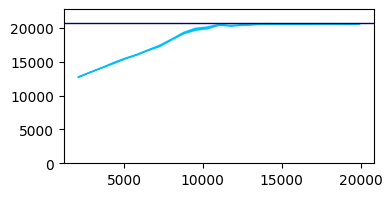

In [13]:
plt.figure(figsize=(4, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.1)

In [205]:
# Remove live points depending on fit
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    # irange = np.linspace(ndead, len(points), 720, endpoint=False).astype(int)
    logL = points.logL.iloc[ndead:]#.iloc[irange]
    logX = points.logX()
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        # theta = minimise_exclude(logL, X[irange], print_split=True)
        theta = minimise_exclude(logL, X[ndead:], print_split=False)
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    print(f"{ndead}/{iterations[-1]}, {formatt(np.median(thetas, axis=0))}")

2067/19927, ['-10.85', '1.42', '0.02']
2811/19927, ['-10.10', '1.47', '0.02']
3555/19927, ['-9.38', '1.54', '0.02']
4299/19927, ['-8.37', '1.63', '0.03']
5043/19927, ['-7.19', '1.83', '0.03']
5788/19927, ['-6.65', '1.89', '0.03']
6532/19927, ['-5.96', '2.02', '0.03']
7276/19927, ['-5.59', '2.10', '0.03']
8020/19927, ['-4.98', '2.37', '0.04']
8764/19927, ['-4.64', '2.45', '0.04']
9509/19927, ['-4.24', '2.43', '0.04']
10253/19927, ['-4.40', '2.34', '0.04']
10997/19927, ['-4.07', '2.80', '0.06']
11741/19927, ['-4.11', '2.74', '0.06']
12485/19927, ['-3.97', '3.10', '0.07']
13230/19927, ['-3.94', '3.24', '0.08']
13974/19927, ['-3.83', '4.02', '0.11']
14718/19927, ['-3.85', '3.89', '0.11']
15462/19927, ['-3.78', '5.08', '0.17']
16206/19927, ['-3.79', '4.90', '0.16']
16951/19927, ['-3.75', '6.04', '0.22']
17695/19927, ['-3.73', '6.99', '0.27']
18439/19927, ['-3.73', '7.22', '0.29']
19183/19927, ['-3.74', '6.80', '0.27']
19927/19927, ['-3.70', '9.59', '0.43']


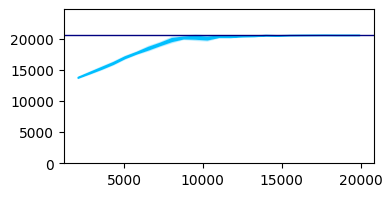

In [206]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

In [209]:
# Removing last few points if they cause overflow
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
trunc = 15
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = points.logL.iloc[ndead:]
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        theta = minimise_bandwidth(logL, X[ndead:], logZdead, print_split=False)
        attempt = 1
        while np.isnan(logXf_formula(theta, logZdead, X[ndead])):
            theta = minimise_bandwidth(logL[:-attempt*trunc], X[ndead:-attempt*trunc], logZdead, print_split=False)
            attempt += 1
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    # logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    print(f"{ndead}/{iterations[-1]}, {len(logXfs_i)}, {formatt(np.median(thetas, axis=0))}")#, {formatt(np.mean(thetas, axis=0))}")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


2067/19927, 22, ['-10.92', '1.41', '0.02']
2811/19927, 25, ['-10.11', '1.46', '0.02']
3555/19927, 25, ['-9.26', '1.55', '0.02']
4299/19927, 22, ['-8.54', '1.64', '0.03']
5043/19927, 25, ['-7.19', '1.76', '0.03']
5788/19927, 18, ['-6.80', '1.86', '0.03']
6532/19927, 24, ['-5.80', '2.08', '0.03']
7276/19927, 24, ['-5.70', '2.17', '0.04']
8020/19927, 25, ['-4.83', '2.37', '0.04']
8764/19927, 24, ['-4.68', '2.51', '0.04']
9509/19927, 22, ['-4.11', '2.52', '0.04']
10253/19927, 22, ['-4.37', '2.32', '0.04']
10997/19927, 21, ['-4.06', '2.86', '0.06']
11741/19927, 23, ['-4.13', '2.74', '0.05']
12485/19927, 25, ['-3.97', '3.03', '0.07']
13230/19927, 25, ['-3.93', '3.32', '0.08']
13974/19927, 22, ['-3.84', '4.01', '0.11']
14718/19927, 25, ['-3.86', '3.92', '0.11']
15462/19927, 25, ['-3.79', '4.87', '0.16']
16206/19927, 24, ['-3.78', '5.10', '0.17']
16951/19927, 24, ['-3.76', '6.07', '0.22']
17695/19927, 24, ['-3.72', '7.50', '0.29']
18439/19927, 24, ['-3.72', '7.32', '0.29']
19183/19927, 22, ['-

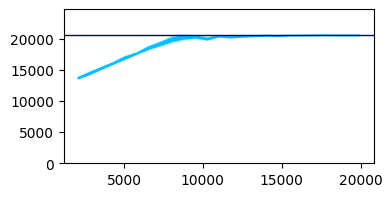

In [210]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

#### Cauchy

In [296]:
samples = pickle_in("../../samples/toy/cauchy_10_0001.pickle")
model = EndModel(samples)
inc = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = inc.true_endpoint
logZs = inc.logZ

In [304]:
# Vanilla approach
iterations = np.linspace(true_endpoint*0.01, true_endpoint, 25, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=50)
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=500)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


Iteration 479/46094
Iteration 2380/46094
Iteration 4281/46094
Iteration 6181/46094


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  >>> a[0, :] = 1.0
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = arr.dtype.type(ret / rcount)
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  return ret
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  div = rcount.reshape(arrmean.shape)
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  with _no_nep50_warning():


Iteration 8082/46094
Iteration 9982/46094
Iteration 11883/46094
Iteration 13784/46094
Iteration 15684/46094
Iteration 17585/46094
Iteration 19485/46094
Iteration 21386/46094
Iteration 23287/46094
Iteration 25187/46094
Iteration 27088/46094
Iteration 28988/46094
Iteration 30889/46094
Iteration 32790/46094
Iteration 34690/46094
Iteration 36591/46094
Iteration 38491/46094
Iteration 40392/46094
Iteration 42293/46094
Iteration 44193/46094
Iteration 46094/46094


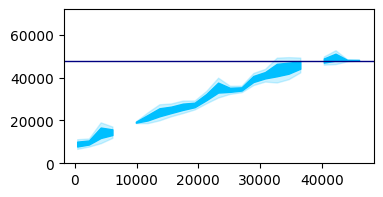

In [306]:
plt.figure(figsize=(4, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

In [302]:
# Exclude live points without skipping fits that overflow
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    # irange = np.linspace(ndead, len(points), 720, endpoint=False).astype(int)
    logL = points.logL.iloc[ndead:]#.iloc[irange]
    logX = points.logX()
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        # theta = minimise_exclude(logL, X[irange], print_split=True)
        theta = minimise_exclude(logL, X[ndead:], print_split=False)
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    print(f"{ndead}/{iterations[-1]}, {formatt(np.median(thetas, axis=0))}")

42811/46267, ['24.24', '76.55', '0.01']
44539/46267, ['2.46', '24.28', '0.01']
46267/46267, ['0.43', '13.55', '0.00']


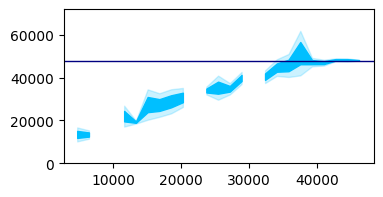

In [303]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=500)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

In [300]:
# Exclude last few points if they cause overflow
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
trunc = 15
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = points.logL.iloc[ndead:]
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        theta = minimise_bandwidth(logL, X[ndead:], logZdead, print_split=False)
        attempt = 1
        while np.isnan(logXf_formula(theta, logZdead, X[ndead])):
            theta = minimise_bandwidth(logL[:-attempt*trunc], X[ndead:-attempt*trunc], logZdead, print_split=False)
            attempt += 1
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    # logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    # print(thetas)
    print(f"{ndead}/{iterations[-1]}, {len(logXfs_i)}, attempts={attempt}")#, {formatt(np.mean(thetas, axis=0))}")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


4799/46267, 20, attempts=1
6527/46267, 20, attempts=1
8255/46267, 21, attempts=6
9982/46267, 24, attempts=1
11710/46267, 21, attempts=14
13438/46267, 23, attempts=1
15166/46267, 20, attempts=1


/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:41: RuntimeWarning: divide by zero encountered in divide
  (Xdata**(2/d)) / (2 * sigma_squared_analytic(d, Xdata, logLdata)) )
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:40: RuntimeWarning: invalid value encountered in subtract
  return logLdata - (logLmax_analytic(d, Xdata, logLdata) - \
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  


16894/46267, 24, attempts=4
18622/46267, 24, attempts=10
20349/46267, 22, attempts=1
22077/46267, 21, attempts=3
23805/46267, 23, attempts=1
25533/46267, 19, attempts=1
27261/46267, 20, attempts=1


/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:15: RuntimeWarning: invalid value encountered in double_scalars
  return numerator/denominator


28988/46267, 24, attempts=3
30716/46267, 23, attempts=7
32444/46267, 21, attempts=1
34172/46267, 19, attempts=3
35900/46267, 23, attempts=1
37628/46267, 19, attempts=1
39355/46267, 22, attempts=2
41083/46267, 19, attempts=1
42811/46267, 22, attempts=1
44539/46267, 22, attempts=1
46267/46267, 25, attempts=1


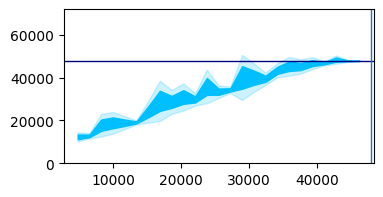

In [301]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=500)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)
plt.axvline(x=true_endpoint, lw=1)

Examine particular iteration

In [183]:
ndead = 35036
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
logL = points.logL.iloc[ndead:]
logXfs_i = np.zeros(Nset)
for i in range(Nset):
    X = generate_Xs(nk)
    theta = minimise_bandwidth(logL, X[ndead:], logZdead, print_split=False)
    print(theta)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


[6670.853755188881, 11512.75093099571, 0.008588963738548285]
[-0.5601445769144497, 35.06134102146257, 0.019436838305000852]
[8320.95309841315, 14078.38281472836, 0.007701921412038281]
[6962.31725891635, 11684.403515831222, 0.008408689231506405]
[13.664138294208858, 66.85704307785129, 0.04017917940333049]
[6366.3932177915885, 10502.636715971543, 0.00878637116142826]
[4716.98002302827, 8346.101956688699, 0.01018285660695617]
[5867.167149298504, 9459.686900048442, 0.009144241355625372]
[6867.283334500096, 11645.950186456843, 0.00846655994054622]
[4673.259484186025, 7941.728409185539, 0.010226125462212108]


In [191]:
ndead = 35036
logZdead = logZs.iloc[ndead]
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
X = generate_Xs(nk)

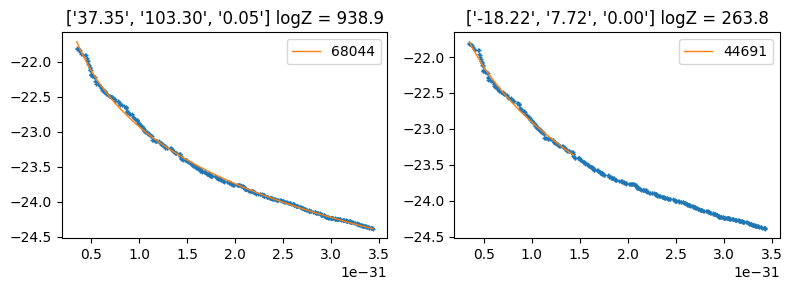

In [193]:
# Showing non-Gaussian/prior artefact at early iterations, which causes poor predictions
ndead = 35036
logZdead = logZs.iloc[ndead]
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
irange = np.linspace(ndead, len(points), 240, endpoint=False).astype(int)
# logXi, logLi = points.logX().iloc[irange], points.logL.iloc[irange]
trunc = 45
splits = 3
logXi, logLi = points.logX().iloc[ndead:-trunc], points.logL.iloc[ndead:-trunc]
# Xi, Li = np.exp(logXi), np.exp(logLi)
Xi = pd.Series(X[ndead:-trunc])
start = len(Xi) - int(len(Xi)/splits)
Xi1, logLi1 = Xi[start:], logLi[start:]

regress = GaussianRegress(logLi, Xi)
regress1 = GaussianRegress(logLi1, Xi1)

logXf = logXf_formula(regress.theta, logZdead, Xi.iloc[0])
endpoint = endpoints_calc(ndead, np.log(Xi.iloc[0]), logXf, 0.01, nlive=1000)[0]
logXf1 = logXf_formula(regress1.theta, logZdead, Xi.iloc[0])
endpoint1 = endpoints_calc(ndead, np.log(Xi.iloc[0]), logXf1, 0.01, nlive=1000)[0]

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(Xi, logLi, '+', ms=3)
axs[0].plot(Xi, full.func(Xi, regress.theta), lw=1, label=f"{endpoint:.0f}")
axs[0].set_title(f"{[f'{t:.2f}' for t in regress.theta]} logZ = {regress.logZ():.1f}")
axs[0].legend()

axs[1].plot(Xi, logLi, '+', ms=3)
axs[1].plot(Xi1, full.func(Xi1, regress1.theta), lw=1, label=f"{endpoint1:.0f}")
axs[1].set_title(f"{[f'{t:.2f}' for t in regress1.theta]} logZ = {regress1.logZ():.1f}");
axs[1].legend()

# fig.suptitle(f"Theta(40,000): {[f'{t:.2f}' for t in theta_40000]}", y=1.05)
fig.tight_layout()

In [136]:
logXf = logXf_formula(regress.theta, logZdead, Xi.iloc[0])
endpoints_calc(ndead, np.log(Xi.iloc[0]), logXf, 0.01, nlive=1000)

(28768.522865471816, 10.0)

#### Wedding cake

In [272]:
samples = pickle_in("../../samples/toy/wedding_20_001.pickle")
model = EndModel(samples)
inc = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = inc.true_endpoint
logZs = inc.logZ

In [285]:
# Vanilla approach
iterations = np.linspace(true_endpoint*0.01, true_endpoint, 25, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=25)
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=400)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


Iteration 386/37103
Iteration 1916/37103
Iteration 3446/37103
Iteration 4975/37103
Iteration 6505/37103
Iteration 8035/37103
Iteration 9565/37103
Iteration 11095/37103
Iteration 12625/37103
Iteration 14155/37103
Iteration 15684/37103
Iteration 17214/37103
Iteration 18744/37103
Iteration 20274/37103
Iteration 21804/37103
Iteration 23334/37103
Iteration 24864/37103
Iteration 26394/37103


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)


Iteration 27923/37103
Iteration 29453/37103
Iteration 30983/37103
Iteration 32513/37103
Iteration 34043/37103
Iteration 35573/37103
Iteration 37103/37103


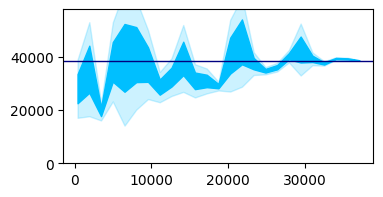

In [286]:
plt.figure(figsize=(4, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

In [292]:
samples.nlive.mean()

375.5510635354411

In [287]:
# Exclude last few points if they cause overflow
iterations = np.linspace(true_endpoint*0.1, true_endpoint*0.99, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
trunc = 15
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = points.logL.iloc[ndead:]
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        theta = minimise_bandwidth(logL, X[ndead:], logZdead, print_split=False)
        attempt = 1
        while np.isnan(logXf_formula(theta, logZdead, X[ndead])):
            theta = minimise_bandwidth(logL[:-attempt*trunc], X[ndead:-attempt*trunc], logZdead, print_split=False)
            attempt += 1
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    # logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    # print(thetas)
    print(f"{ndead}/{iterations[-1]}, {len(logXfs_i)}, attempts={attempt}")#, {formatt(np.mean(thetas, axis=0))}")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


3863/36871, 20, attempts=1


/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


5238/36871, 18, attempts=2
6613/36871, 20, attempts=1
7989/36871, 22, attempts=1


/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:41: RuntimeWarning: divide by zero encountered in divide
  (Xdata**(2/d)) / (2 * sigma_squared_analytic(d, Xdata, logLdata)) )
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:40: RuntimeWarning: invalid value encountered in subtract
  return logLdata - (logLmax_analytic(d, Xdata, logLdata) - \
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  


9364/36871, 20, attempts=1
10739/36871, 18, attempts=1
12115/36871, 18, attempts=5
13490/36871, 19, attempts=2
14865/36871, 21, attempts=1
16241/36871, 19, attempts=1
17616/36871, 23, attempts=5
18991/36871, 16, attempts=2
20367/36871, 18, attempts=1
21742/36871, 20, attempts=1
23117/36871, 22, attempts=1
24493/36871, 22, attempts=1
25868/36871, 21, attempts=1


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:15: RuntimeWarning: invalid value encountered in double_scalars
  return numerator/denominator


27243/36871, 22, attempts=1
28619/36871, 20, attempts=3
29994/36871, 19, attempts=1
31369/36871, 22, attempts=4
32745/36871, 22, attempts=1


/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator/denominator
/home/zixiao/Documents/III/project/aeons/aeons/lm_partial.py:28: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigma_squared_analytic(d, Xdata, logLdata))
/tmp/ipykernel_216225/1356916762.py:27: RuntimeWarning: divide by zero encountered in log
  return -1/2 * self.N * np.log(2*np.pi*s**2) - L_sq/(2*s**2)
/tmp/ipykernel_216225/1356916762.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return -1/2 * self.N * np.log(2*np.pi*s**2) - L_sq/(2*s**2)


34120/36871, 21, attempts=1
35496/36871, 24, attempts=1
36871/36871, 24, attempts=1


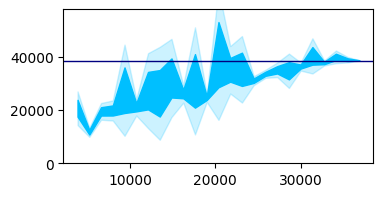

In [295]:
plt.figure(figsize=(4, 2))
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=400)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)
# plt.axvline(x=true_endpoint, lw=1)

#### GP chains

In [7]:
from anesthetic import read_chains

samples = read_chains(root="gp_chains/samples")
model = EndModel(samples)
inc = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = inc.true_endpoint
logZs = inc.logZ

/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:69: RuntimeWarning: overflow encountered in exp
  self.L = np.exp(self.logL)


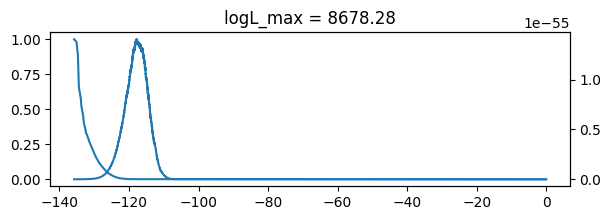

In [8]:
model.plot_lx()

In [326]:
iterations = np.linspace(0.1 * true_endpoint, true_endpoint, 10, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=10)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 9172/83466


/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


Iteration 17426/83466
Iteration 25681/83466


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)


Iteration 33936/83466
Iteration 42191/83466
Iteration 50446/83466


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  >>> a[0, :] = 1.0
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = arr.dtype.type(ret / rcount)
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  return ret
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  div = rcount.reshape(arrmean.shape)
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  with _no_nep50_warning():


Iteration 58701/83466
Iteration 66956/83466
Iteration 75211/83466
Iteration 83466/83466


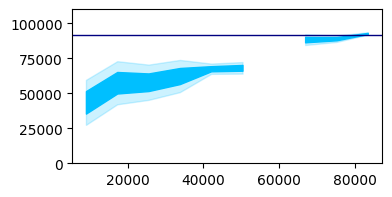

In [330]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=750)
plt.figure(figsize=(4,2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

In [353]:
# Exclude last few points if they cause overflow
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
trunc = 15
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = points.logL.iloc[ndead:]
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        theta = minimise_bandwidth(logL, X[ndead:], logZdead, print_split=False)
        attempt = 1
        while np.isnan(logXf_formula(theta, logZdead, X[ndead])):
            theta = minimise_bandwidth(logL[:-attempt*trunc], X[ndead:-attempt*trunc], logZdead, print_split=False)
            attempt += 1
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    # logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    # print(thetas)
    print(f"{ndead}/{iterations[-1]}, {len(logXfs_i)}, attempts={attempt}")#, {formatt(np.mean(thetas, axis=0))}")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


9172/88419, 21, attempts=1
12474/88419, 21, attempts=1
15776/88419, 21, attempts=1
19077/88419, 18, attempts=1
22379/88419, 22, attempts=1
25681/88419, 22, attempts=1


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)


28983/88419, 18, attempts=2
32285/88419, 22, attempts=1
35587/88419, 21, attempts=1
38889/88419, 22, attempts=1
42191/88419, 19, attempts=3
45493/88419, 20, attempts=2
48795/88419, 21, attempts=1
52097/88419, 18, attempts=1
55399/88419, 23, attempts=1
58701/88419, 20, attempts=1
62003/88419, 22, attempts=1
65305/88419, 21, attempts=3
68607/88419, 24, attempts=10
71909/88419, 22, attempts=2
75211/88419, 23, attempts=1
78513/88419, 21, attempts=1
81815/88419, 22, attempts=1
85117/88419, 21, attempts=1
88419/88419, 24, attempts=1


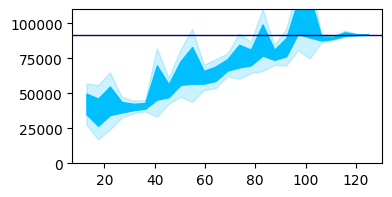

In [366]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=750)
plt.figure(figsize=(4,2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2, logX_vals=logXs)

### **DKL**

In [11]:
from anesthetic.examples.perfect_ns import planck_gaussian
from anesthetic.examples.perfect_ns import correlated_gaussian

samples = planck_gaussian()
beta = np.logspace(-10, 0, 100)
D_KL = samples.D_KL(nsamples=30, beta=np.logspace(-10, 0, 100))
D_KL.unstack('samples').plot()

: 

: 

### **Confidence in prediction parameters**

##### Testing with BAO

In [401]:
name, samples = get_samples('lcdm', 'BAO')
model = EndModel(samples)
true_endpoint = IncrementEndpoint(samples, N_rolling=500).true_endpoint
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 10, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=10)
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=1000)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 1812/16497
Iteration 3444/16497
Iteration 5076/16497
Iteration 6707/16497
Iteration 8339/16497
Iteration 9970/16497
Iteration 11602/16497
Iteration 13234/16497
Iteration 14865/16497
Iteration 16497/16497


Plot of endpoint predictions for BAO; uncertainty estimate too low at beginning

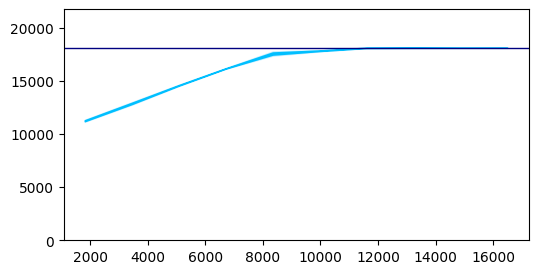

In [402]:
plt.figure(figsize=(6, 3))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


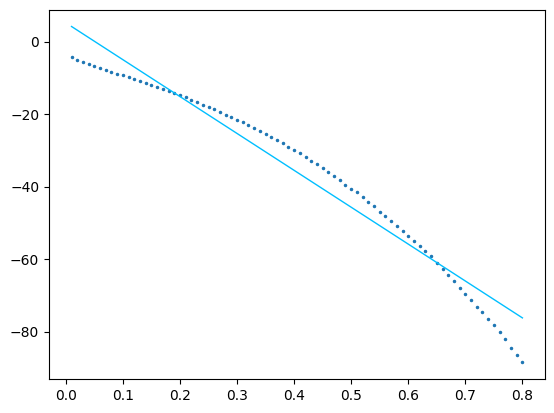

In [474]:
ndeads = samples.index.get_level_values(0)
logL, logX = samples.logL, samples.logX()
L, X = np.exp(logL), np.exp(logX)

ndead = 2000
points = model.points(ndead)
# theta = model.minimise(ndead)
logXi, logLi = points.logX().iloc[ndead::100], points.logL.iloc[ndead::100]
theta = analytic_lm_params(logLi, np.exp(logXi), d0=5, bounds=(2, np.inf))
Xi, Li = np.exp(logXi), np.exp(logLi)
ls = LS(np.array(logLi), full, np.array(Xi))
covtheta = ls.covtheta(theta)
logL_pred = full.func(Xi, theta)

fig, ax = plt.subplots()
# ax.plot(X, logL, color='black')
ax.plot(Xi, logLi, '.', ms=3)
# for i in range(10):
#     thetai = np.random.multivariate_normal(theta, covtheta)
#     ax.plot(Xi, full.func(Xi, thetai), alpha=.5, color='deepskyblue', lw=.5)
#     print(thetai)
ax.plot(Xi, full.func(Xi, theta), color='deepskyblue', lw=1)

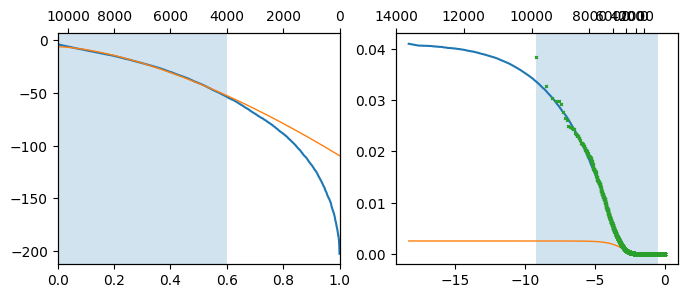

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1a = plt.twiny(ax1)
ax1.plot(X, logL)
ax1.set_xlim(0, 1)
ax1a.set_xticks(X[::2000][:-4])
ax1a.set_xticklabels(ndeads[::2000][:-4]);

ax2a = plt.twiny(ax2)
ax2.plot(logX, L)
ax2a.set_xticks(logX[::2000][:-2])
ax2a.set_xticklabels(ndeads[::2000][:-2]);

ndead = 4000
points = model.points(ndead)
theta = model.minimise(ndead)
logL_pred = full.func(X, theta)
X_pred = np.exp(points.logX())
ax1.axvspan(X_pred.iloc[ndead], X_pred.iloc[-1], alpha=0.2)
ax2.axvspan(np.log(X_pred.iloc[ndead]), np.log(X_pred.iloc[-1]), alpha=0.2)
ax1.plot(X, logL_pred, lw=1)
ax2.plot(logX, np.exp(logL_pred), lw=1)
ax2.plot(points.logX(), np.exp(points.logL), 'x', ms=2)

##### Trying the same with Cauchy

In [61]:
samples = pickle_in('../../samples/toy/cauchy_10_0001.pickle')
model = EndModel(samples)
true_endpoint = IncrementEndpoint(samples, N_rolling=500).true_endpoint

In [203]:
ndead = 4000
points = model.points(ndead)
logL, logX = samples.logL, samples.logX()
L, X = np.exp(logL), np.exp(logX)
logXi, logLi = points.logX(), points.logL
Xi, Li = np.exp(logXi), np.exp(logLi)

theta = model.minimise(ndead)
logL_pred = full.func(X, theta)
theta

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


[7087.917906585264, 12088.973098691484, 0.008339064538613876]

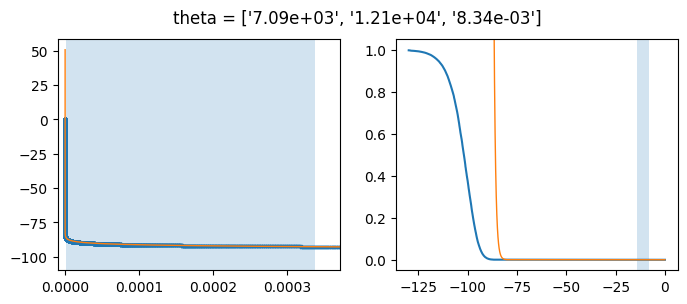

In [236]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(X, logL, 'x', ms=2)
ax1.axvspan(Xi.iloc[ndead], Xi.iloc[-1], alpha=0.2)
ax1.set_xlim(-1e-5, np.exp(points.logX().iloc[ndead])*1.1)
ax1.plot(X, logL_pred, lw=1)

ax2.plot(logX, L)
ax2.axvspan(logXi.iloc[ndead], logXi.iloc[-1], alpha=0.2)
ax2.plot(logX, np.exp(logL_pred), lw=1)
ax2.set_ylim(-0.05, 1.05)
fig.suptitle(f'theta = {[f"{t:.2e}" for t in theta]}');

In [279]:
from aeons.models import LS

ls = LS(np.array(logLi), full, np.array(Xi))
covtheta = ls.covtheta(theta)
for i in range(3):
    print(f'{theta[i]:.3f} +/- {np.sqrt(covtheta[i][i]):.1e}')

7087.918 +/- 8.0e-01
12088.973 +/- 3.1e+01
0.008 +/- 4.6e-07


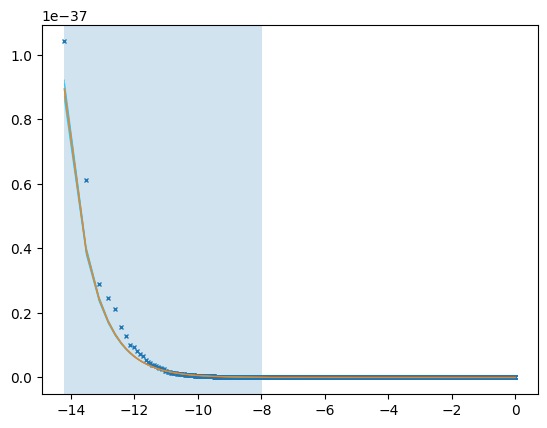

In [280]:
plt.plot(logXi, Li, 'x', ms=3)
for i in range(10):
    thetai = np.random.multivariate_normal(theta, cov=covtheta)
    plt.plot(logXi, np.exp(full.func(Xi, thetai)), lw=.5, alpha=.5, color='deepskyblue')
plt.plot(logXi, np.exp(full.func(Xi, theta)), lw=1)
plt.axvspan(logXi.iloc[ndead], logXi.iloc[-1], alpha=0.2)

In [133]:
def minimise(logL, logX, x0):
    def func(theta):
        X = np.exp(logX)
        return np.sum((logL - full.func(X, theta))**2)
    from scipy.optimize import minimize
    return minimize(func, x0)

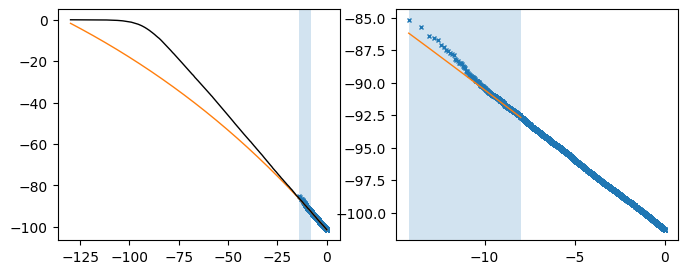

In [156]:
theta_L = minimise(logLi, logXi, [1, 10, 0.1]).x

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3))
ax1.plot(logXi, logLi, 'x', ms=3)
ax1.plot(logX, full.func(X, theta_L), lw=1)
ax1.plot(logX, logL, lw=1, color='black')
ax1.axvspan(logXi.iloc[ndead], logXi.iloc[-1], alpha=0.2)

ax2.plot(logXi, logLi, 'x', ms=3)
ax2.plot(logXi.iloc[ndead:], full.func(Xi.iloc[ndead:], theta_L), lw=1)
ax2.axvspan(logXi.iloc[ndead], logXi.iloc[-1], alpha=0.2)

### Planck lensing BAO tests

In [19]:
from aeons.true_distribution import generate_Xs
from aeons.endpoint import reject_outliers
from aeons.covariance import points_at_iteration, logX_mu
from scipy.special import logsumexp

def reject_std(data):
    mean = np.mean(data)
    std = np.std(data)
    data = data[abs(data - mean) < 2*std]
    return data

def data(ndead):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    logZdead = logsumexp(points.logw()[:ndead])
    return logL, nk, logZdead

def calc_logXfs(iterations, Nset=None, epsilon=1e-3):
    N = len(iterations)
    logXfs = np.zeros(N)
    logXfs_std = np.zeros(N)
    for i, ndead in enumerate(iterations):
        logL, nk, logZdead = data(ndead)
        logXf_i = np.zeros(Nset)
        for j in range(Nset):
            X = generate_Xs(nk)
            theta = analytic_lm_params(logL[ndead:], X[ndead:], 1)
            logXf_i[j] = logXf_formula(theta, logZdead, X[ndead], epsilon)
        logXf_i = logXf_i[~np.isnan(logXf_i)]
        logXf_i = reject_outliers(logXf_i)
        logXfs[i] = np.mean(logXf_i)
        logXfs_std[i] = np.std(logXf_i)

        nlive = len(logL) - ndead
        N_fits = np.linspace(10, 1000, 10).astype(int)
        logXfs_test = np.zeros(len(N_fits))
        logX_mean = logX_mu(nk)
        for k, N_fit in enumerate(N_fits):
            theta = analytic_lm_params(logL[-N_fit:], np.exp(logX_mean[-N_fit:]), 1)
            logXfs_test[k] = logXf_formula(theta, logZdead, np.exp(logX_mean[ndead]))
        logXfs_test = reject_std(logXfs_test)
        if np.std(logXfs_test) > np.std(logXf_i):
            logXfs_std[i] = np.std(logXfs_test)
            print(np.std(logXfs_test), np.std(logXf_i))
        print(ndead, nlive)
    return logXfs, logXfs_std

In [20]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 10, endpoint=False).astype(int)
logXf, logXf_std = calc_logXfs(iterations, Nset=10)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


1.7645011103222465 0.11577103737614605
5785 4215
10991 1000
3.5768141247028518 1.3250909742915349
16198 1000
1.189520107821849 0.8970649825493484
21405 1000


/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/endpoint.py:24: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


26611 1000
6.554534797137108 1.1132329691519411
31818 1000
37025 1000
42231 1000


KeyboardInterrupt: 

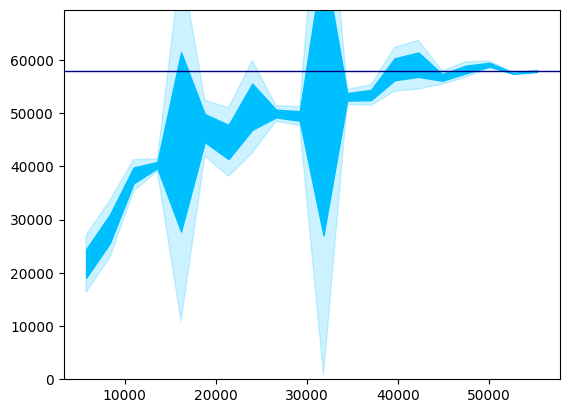

In [18]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXf, logXf_std, nlive=1000)
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2)

In [540]:
N_fits = np.linspace(20, 1000, 25).astype(int)
logXfs = np.zeros(len(N_fits))
for i, N_fit in enumerate(N_fits):
    theta = analytic_lm_params(points.logL[-N_fit:], np.exp(points.logX()[-N_fit:]), 1)
    logXf = logXf_formula(theta, logZdead, Xi)
    logXfs[i] = logXf

NameError: name 'points' is not defined

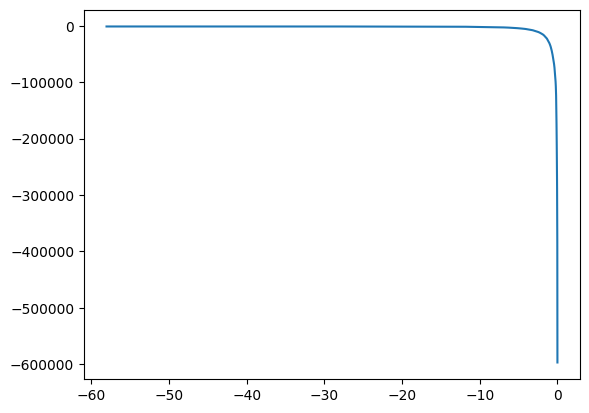

In [21]:
plt.plot(samples.logX()[::3], samples.logL[::3])
plt.plot(points.logX(), points.logL)
plt.plot(samples.logX()[::3], full.func(np.exp(samples.logX()[::3]), theta))
plt.ylim(-10000, 0)

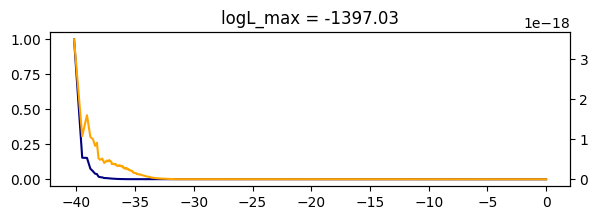

In [304]:
def plot_lx(points):
    logX = points.logX()
    fig, ax1 = plt.subplots(figsize=(6.7,2))
    ax2 = plt.twinx(ax1)
    logL_norm = points.logL - points.logL.max()
    L_norm = np.exp(logL_norm)
    ax1.plot(logX, L_norm, color='navy')
    ax2.plot(logX, L_norm*np.exp(logX), color='orange')
    ax1.set_title(f'logL_max = {points.logL.max():.2f}')
plot_lx(points)

In [170]:
logL = np.array(points.logL)[ndead:]
nk = np.array(points.nlive)
logX = logX_mu(nk)[ndead:]
L = np.exp(logL)

### Uncertainty in d

In [189]:
name, samples = get_samples('lcdm', 'planck_lensing_BAO')
model = EndModel(samples)
true_endpoint = IncrementEndpoint(samples, N_rolling=500).true_endpoint

In [245]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 10, endpoint=False).astype(int)
for i in iterations:
    d = model.minimise(i)[1]
    print(i, d)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


5785 1.7597119040944909
10991 5.163375205117868
16198 7.264358644569086
21405 7.339306075387184
26611 9.596837659806768
31818 12.701182212293322
37025 13.200958565232813
42231 22.708223786696266
47438 29.70405629618017
52645 16.094755197698817


In [266]:
from aeons.lm_partial import analytic_lm

In [280]:
name, samples = get_samples('lcdm', 'planck_lensing_BAO')
model = EndModel(samples)
true_endpoint = IncrementEndpoint(samples, N_rolling=500).true_endpoint

N = 10
iterations = np.linspace(true_endpoint*0.1, true_endpoint, N, endpoint=False).astype(int)
ds = np.zeros(N)
for i, iteration in enumerate(iterations):
    points = pd.concat([samples[:iteration], samples.live_points(iteration)])
    points = points.reset_index(drop=True).recompute()
    logL = np.array(points.logL)[iteration:]
    nk = np.array(points.nlive)
    logX = logX_mu(nk)[iteration:]
    X = np.exp(logX)
    d = analytic_lm(logL, X, 1).x
    ds[i] = d
    print(i)

0
1
2
3
4
5
6
7
8
9


16.746230805310454

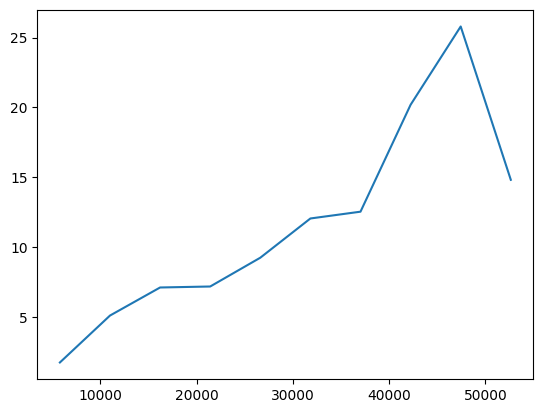

In [281]:
plt.plot(iterations, ds)
samples.d_G()

In [247]:
%matplotlib
samples.gui()

Using matplotlib backend: TkAgg
